# Whole brain data processing

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def force_bkill_dask():
    try:
        get_ipython().run_cell_magic('bash', '', 'bkill -q normal 0\n')
    except:
        get_ipython().run_cell_magic('bash', '', 'bjobs\n')

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [3]:
## STEP 1: specify data and save path
dir_root = '/groups/ahrens/ahrenslab/jing/giving_up/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013'
if not os.path.exists(save_root):
    os.makedirs(save_root)

In [4]:
nsplit = 8
baseline_percentile = 20  
baseline_window = 400   # number of frames

## Compute df/f
One of three choices
* df is from NMF components (where background is not included) -- preferred
* df is on raw data based on the recomputation of cell F using NMF weights
* df/f on pixels without using NMF weights

### df/f on pixels

In [5]:
cluster, client = fdask.setup_workers(10)
client

Client Scheduler: tcp://10.36.111.12:35546 Dashboard: http://10.36.111.12:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# numCores = 70
# dff = compute_cell_dff_pixels(save_root, 
#                               numCores=numCores, 
#                               window=baseline_window, 
#                               percentile=baseline_percentile)

In [7]:
def baseline_from_Yd(block_t, block_d):
    min_t = np.percentile(block_t, 0.3, axis=-1, keepdims=True)
    min_t[min_t>0] = 0
    return block_t - block_d - min_t

In [8]:
# dff on raw data
trans_data_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
baseline_t = da.map_blocks(baseline_from_Yd, trans_data_t, Y_d, dtype='float32')
_, nx, ny, _ = trans_data_t.chunksize
dff = Y_d/baseline_t

In [9]:
# dff on denoised data
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')
dff_ = Y_svd/baseline_t

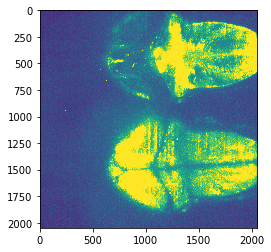

In [10]:
img = Y_d[14].max(axis=-1).compute()
plt.imshow(img, vmax = np.percentile(img, 90))
plt.show()

In [ ]:
np.where(img == img.max())

(array([1812]), array([1987]))

In [ ]:
plt.plot(trans_data_t[14, 1812, 1987])
plt.plot(baseline_t[14, 1812, 1987])
plt.ylim([0, 10])
plt.title('Baseline on raw data')
plt.show()

plt.plot(Y_d[14, 1812, 1987])
plt.plot(Y_svd[14, 1812, 1987])
plt.ylim([0, 10])
plt.show()

plt.plot(dff[14, 1812, 1987])
plt.plot(dff_[14, 1812, 1987])
plt.ylim([0, 10])
plt.show()

In [ ]:
cluster.stop_all_jobs()

In [ ]:
force_bkill_dask()

### df/f on raw cell data

In [ ]:
compute_cell_dff_raw(save_root, 
                     numCores=numCores, 
                     window=baseline_window, 
                     percentile=baseline_percentile, 
                     nsplit=nsplit)

### df/f on denoised cell data

In [ ]:
compute_cell_dff_NMF(save_root, 
                     numCores=numCores, 
                     window=baseline_window, 
                     percentile=baseline_percentile, 
                     nsplit=nsplit, dt=dt)